In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
import networkx as nx
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('Final_Ridership_Demographics.csv')
print(df.columns)

Index(['station_complex_id', 'netRidership', 'total_spending',
       'avg_fare_per_ride', 'Metrocard - Fair Fare_pct',
       'Metrocard - Full Fare_pct', 'Metrocard - Other_pct',
       'Metrocard - Seniors & Disability_pct', 'Metrocard - Students_pct',
       'Metrocard - Unlimited 30-Day_pct', 'Metrocard - Unlimited 7-Day_pct',
       'OMNY - Full Fare_pct', 'OMNY - Other_pct',
       'OMNY - Seniors & Disability_pct', 'Latitude', 'Longitude',
       'MEAN_Median_Inc', 'Male_Total_pct', 'Female_Tot_pct', 'White_Alon_pct',
       'Black_Alon_pct', 'Hispanic_L_pct', 'Non_Hispan_pct'],
      dtype='object')


In [3]:
df.dropna(inplace=True)

df['MEAN_Median_Inc'] = pd.to_numeric(df['MEAN_Median_Inc'], errors='coerce')
df = df[df['MEAN_Median_Inc'] > 0] 
df['fare_burden_per_rider'] = df['avg_fare_per_ride'] / df['MEAN_Median_Inc']
df.head()

,station_complex_id,netRidership,total_spending,avg_fare_per_ride,Metrocard - Fair Fare_pct,Metrocard - Full Fare_pct,Metrocard - Other_pct,Metrocard - Seniors & Disability_pct,Metrocard - Students_pct,Metrocard - Unlimited 30-Day_pct,...,Latitude,Longitude,MEAN_Median_Inc,Male_Total_pct,Female_Tot_pct,White_Alon_pct,Black_Alon_pct,Hispanic_L_pct,Non_Hispan_pct,fare_burden_per_rider
0,1,1271659,3088173.45,2.428460,0.015479,0.198511,0.052030,0.026712,0.048286,0.134144,...,40.775036,-73.912034,107187.30000,0.500531,0.499469,0.652126,0.030850,0.786273,0.213727,0.000023
1,10,606571,1533035.78,2.527381,0.014135,0.187991,0.028043,0.019337,0.018549,0.067893,...,40.759901,-73.984139,116506.00000,0.581989,0.418011,0.602526,0.067479,0.864149,0.135851,0.000022
2,100,172148,421531.77,2.448659,0.029626,0.137324,0.034470,0.036225,0.044642,0.105316,...,40.706870,-73.953431,58047.11111,0.495446,0.504554,0.630317,0.048921,0.725970,0.274030,0.000042
3,101,704067,1748666.77,2.483665,0.036553,0.132672,0.044001,0.034659,0.040184,0.085647,...,40.708359,-73.957757,96845.63636,0.490270,0.509730,0.654078,0.046692,0.733830,0.266170,0.000026
4,103,85369,203469.10,2.383407,0.044372,0.138036,0.045825,0.026508,0.048530,0.090548,...,40.720280,-73.993915,89467.00000,0.489717,0.510283,0.447210,0.045911,0.879574,0.120426,0.000027


## Fare burden cluster analysis

### Based on the demographic characteristics of the stations, the stations are automatically grouped to see if there are significant differences in the fare burden of different groups.

In [4]:
# features = ['MEAN_Median_Inc', 'White_Alon_pct', 'Black_Alon_pct', 'Hispanic_L_pct', 'Non_Hispan_pct']
features = ['White_Alon_pct', 'Black_Alon_pct', 'Hispanic_L_pct', 'Non_Hispan_pct', 'Male_Total_pct', 'Female_Tot_pct']

df_selected = df[features]
df_selected.head()

,White_Alon_pct,Black_Alon_pct,Hispanic_L_pct,Non_Hispan_pct,Male_Total_pct,Female_Tot_pct
0,0.652126,0.030850,0.786273,0.213727,0.500531,0.499469
1,0.602526,0.067479,0.864149,0.135851,0.581989,0.418011
2,0.630317,0.048921,0.725970,0.274030,0.495446,0.504554
3,0.654078,0.046692,0.733830,0.266170,0.490270,0.509730
4,0.447210,0.045911,0.879574,0.120426,0.489717,0.510283


In [5]:
# Fill with the median of the column
# df_selected = df_selected.fillna(df_selected.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled.head()


,White_Alon_pct,Black_Alon_pct,Hispanic_L_pct,Non_Hispan_pct,Male_Total_pct,Female_Tot_pct
0,1.168708,-0.841680,0.409775,-0.409775,0.636715,-0.636715
1,0.953762,-0.658005,0.785871,-0.785871,3.522150,-3.522150
2,1.074195,-0.751062,0.118546,-0.118546,0.456605,-0.456605
3,1.177166,-0.762238,0.156504,-0.156504,0.273242,-0.273242
4,0.280696,-0.766156,0.860363,-0.860363,0.253670,-0.253670


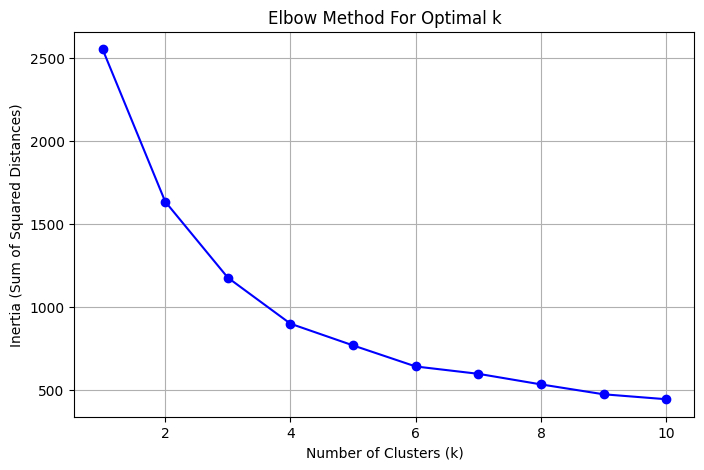

In [6]:
k_range = range(1, 11)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_) 


plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


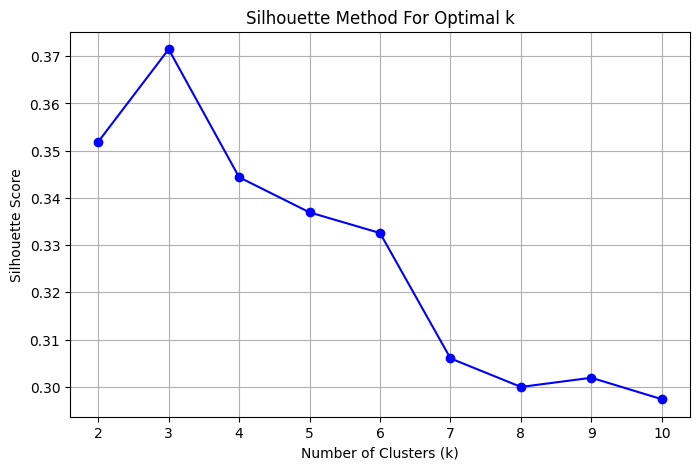

In [7]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.grid(True)
plt.show()


In [8]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

df['cluster'] = cluster_labels

print(df['cluster'].value_counts())

cluster
0    209
1    123
2     93
Name: count, dtype: int64


The mean fare burden per rider for each cluster group is:
cluster
0    0.000024
1    0.000043
2    0.000034
Name: fare_burden_per_rider, dtype: float64


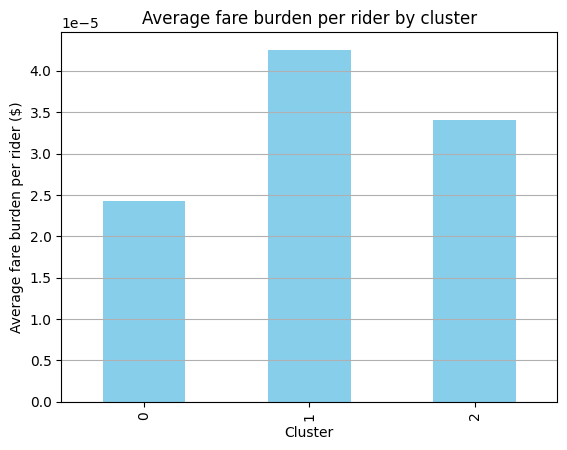

In [9]:
group_fare_mean = df.groupby('cluster')['fare_burden_per_rider'].mean()
print("The mean fare burden per rider for each cluster group is:")
print(group_fare_mean)

group_fare_mean.plot(kind='bar', color='skyblue')
plt.title('Average fare burden per rider by cluster')
plt.xlabel('Cluster')
plt.ylabel('Average fare burden per rider ($)')
plt.grid(axis='y')
plt.show()


In [10]:
# ANOVA test for differences in ticket prices between groups

fare_cluster0 = df[df['cluster'] == 0]['fare_burden_per_rider']
fare_cluster1 = df[df['cluster'] == 1]['fare_burden_per_rider']
fare_cluster2 = df[df['cluster'] == 2]['fare_burden_per_rider']

f_stat, p_value = f_oneway(fare_cluster0, fare_cluster1, fare_cluster2)

print(f"F value of ANOVA test: {f_stat:.4f}")
print(f"P value of ANOVA test: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Significant differences in fare burden across clusters.")
else:
    print("Result: No significant differences in fare burden across clusters.")

F value of ANOVA test: 132.1602
P value of ANOVA test: 0.0000
Result: Significant differences in fare burden across clusters.


### Different station groups clustered by demographic characteristics have real and significant differences in fare burden levels, which shows that the clustering grouping is meaningful and not random.

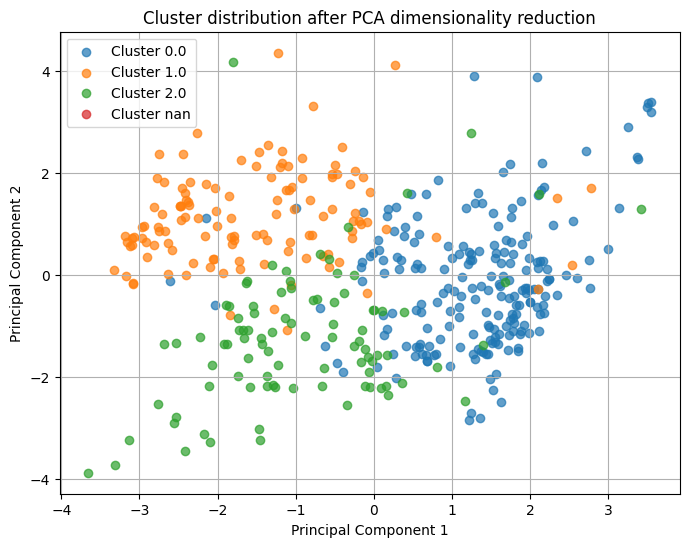

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

plt.figure(figsize=(8,6))
for cluster in df_pca['cluster'].unique():
    subset = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('Cluster distribution after PCA dimensionality reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


### The variation in fare burdens among cluster groups suggests that demographic composition may play a significant role in shaping fare inequality.

## Then do a t-test to filter out irrelevant features and build a more reliable Bayesian network.

In [12]:
features = ['MEAN_Median_Inc', 'White_Alon_pct', 'Black_Alon_pct', 'Hispanic_L_pct', 'Non_Hispan_pct', 'Male_Total_pct', 'Female_Tot_pct']

results = []

for feature in features:
    median_value = df[feature].median()
    high_group = df[df[feature] >= median_value]['fare_burden_per_rider']
    low_group = df[df[feature] < median_value]['fare_burden_per_rider']
    
    t_stat, p_value = ttest_ind(high_group, low_group)
    
    results.append({
        'Feature': feature,
        'T-statistic': round(t_stat, 4),
        'P-value': round(p_value, 4),
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

t_test_results = pd.DataFrame(results)
print(t_test_results)

           Feature  T-statistic  P-value Significant (p<0.05)
0  MEAN_Median_Inc     -24.2208   0.0000                  Yes
1   White_Alon_pct     -15.3300   0.0000                  Yes
2   Black_Alon_pct      10.4383   0.0000                  Yes
3   Hispanic_L_pct     -14.6591   0.0000                  Yes
4   Non_Hispan_pct      14.5574   0.0000                  Yes
5   Male_Total_pct      -2.5796   0.0102                  Yes
6   Female_Tot_pct       2.5376   0.0115                  Yes


## Continue to do Bayesian network modeling

In [13]:
# Use KBinsDiscretizer for equal frequency discretization
# n_bins=3 means dividing into three segments; encode='ordinal' means the result is 0/1/2; strategy='quantile' means equal frequency segmentation
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

selected_features = ['fare_burden_per_rider', 'MEAN_Median_Inc', 'White_Alon_pct', 
                     'Black_Alon_pct', 'Hispanic_L_pct', 'Non_Hispan_pct', 
                     'Male_Total_pct', 'Female_Tot_pct']

df_bn_selected = df[selected_features]
# df_bn_selected = df_bn_selected.fillna(df_bn_selected.median())

df_discrete = pd.DataFrame(discretizer.fit_transform(df_bn_selected), columns=selected_features)
df_discrete = df_discrete.astype(int)
df_discrete.head()


,fare_burden_per_rider,MEAN_Median_Inc,White_Alon_pct,Black_Alon_pct,Hispanic_L_pct,Non_Hispan_pct,Male_Total_pct,Female_Tot_pct
0,0,2,2,0,1,1,2,0
1,0,2,2,1,2,0,2,0
2,2,0,2,0,1,1,2,0
3,1,2,2,0,1,1,1,1
4,1,1,1,0,2,0,1,1


In [14]:
hc = HillClimbSearch(df_discrete)

best_model = hc.estimate(scoring_method=BicScore(df_discrete))

print("Learned Bayesian Network edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Bayesian Network edges:
[('MEAN_Median_Inc', 'fare_burden_per_rider'), ('White_Alon_pct', 'MEAN_Median_Inc'), ('White_Alon_pct', 'Black_Alon_pct'), ('White_Alon_pct', 'Hispanic_L_pct'), ('Black_Alon_pct', 'Male_Total_pct'), ('Hispanic_L_pct', 'Non_Hispan_pct'), ('Male_Total_pct', 'Female_Tot_pct')]


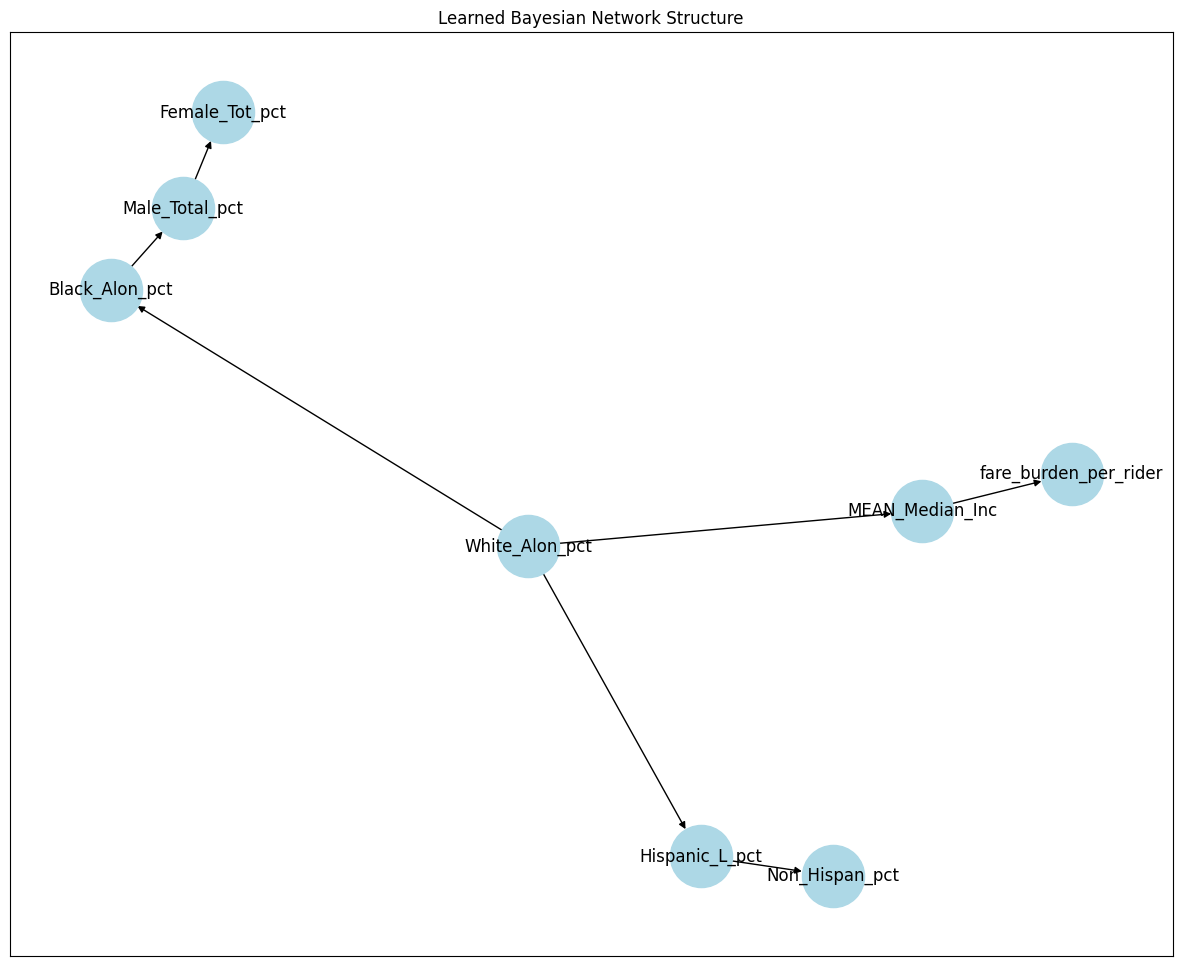

In [15]:
nx_graph = nx.DiGraph(best_model.edges())

plt.figure(figsize=(15,12))
nx.draw_networkx(nx_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, arrows=True)
plt.title('Learned Bayesian Network Structure')
plt.show()

Bayesian Network Structure Interpretation

The learned Bayesian Network reveals several interesting dependencies: 

(1) Fare burden (avg_fare_per_ride) is linked to median income (MEAN_Median_Inc), although the direction suggests fare burden influencing income, which may be due to discretization artifacts and should be interpreted cautiously; 

(2) Median income strongly influences the percentage of the white population (White_Alon_pct), reflecting the socio-economic stratification across neighborhoods; 

(3) The white population percentage further impacts the black population percentage (Black_Alon_pct) and the non-Hispanic population percentage (Non_Hispan_pct); 

(4) Finally, the non-Hispanic population percentage affects the Hispanic population percentage (Hispanic_L_pct). 

These relationships illustrate the interlinked nature of race, income, and fare burden in urban transit contexts.

In [16]:
# Draw a CPT table to describe the direct causal dependency of each edge
bn_model = BayesianNetwork(best_model.edges())
bn_model.fit(df_discrete, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in bn_model.get_cpds():
    print(f"\nCPT for variable {cpd.variable}:")
    print(cpd)



CPT for variable MEAN_Median_Inc:
+--------------------+----------------------+--------------------+---------------------+
| White_Alon_pct     | White_Alon_pct(0)    | White_Alon_pct(1)  | White_Alon_pct(2)   |
+--------------------+----------------------+--------------------+---------------------+
| MEAN_Median_Inc(0) | 0.7068832173240527   | 0.2071651090342679 | 0.0873936581593194  |
+--------------------+----------------------+--------------------+---------------------+
| MEAN_Median_Inc(1) | 0.2892498066511988   | 0.5506230529595015 | 0.15699922660479504 |
+--------------------+----------------------+--------------------+---------------------+
| MEAN_Median_Inc(2) | 0.003866976024748647 | 0.2422118380062305 | 0.7556071152358854  |
+--------------------+----------------------+--------------------+---------------------+

CPT for variable fare_burden_per_rider:
+--------------------------+----------------------+---------------------+----------------------+
| MEAN_Median_Inc         

In [17]:
# Hypothesis Reasoning
infer = VariableElimination(bn_model)

# Group 1: Assuming low median income, infer fare burden
evidence_low_income = {'MEAN_Median_Inc': 0}
posterior_low_income = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_low_income)
print("\nPosterior distribution of fare_burden_per_rider given MEAN_Median_Inc = Low (0):")
print(posterior_low_income)

# Group 2: Assuming high median income, infer fare burden
evidence_high_income = {'MEAN_Median_Inc': 2}
posterior_high_income = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_high_income)
print("\nPosterior distribution of fare_burden_per_rider given MEAN_Median_Inc = High (2):")
print(posterior_high_income)



Posterior distribution of fare_burden_per_rider given MEAN_Median_Inc = Low (0):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.0039 |
+--------------------------+------------------------------+
| fare_burden_per_rider(1) |                       0.0596 |
+--------------------------+------------------------------+
| fare_burden_per_rider(2) |                       0.9366 |
+--------------------------+------------------------------+

Posterior distribution of fare_burden_per_rider given MEAN_Median_Inc = High (2):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.9435 |
+--------------------------+---------------------------

In [18]:
# Group 3: Assuming a high proportion of Black population, infer fare burden
evidence_high_black = {'Black_Alon_pct': 2}
posterior_high_black = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_high_black)
print("\nPosterior distribution of fare_burden_per_rider given Black_Alon_pct = High (2):")
print(posterior_high_black)

# Group 4: Assuming a high proportion of White population, infer fare burden
evidence_high_white = {'White_Alon_pct': 2}
posterior_high_white = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_high_white)
print("\nPosterior distribution of fare_burden_per_rider given White_Alon_pct = High (2):")
print(posterior_high_white)

# Group 5: Assuming a high proportion of Hispanic population, infer fare burden
evidence_high_hispanic = {'Hispanic_L_pct': 2}
posterior_high_hispanic = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_high_hispanic)
print("\nPosterior distribution of fare_burden_per_rider given Hispanic_L_pct = High (2):")
print(posterior_high_hispanic)



Posterior distribution of fare_burden_per_rider given Black_Alon_pct = High (2):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.0945 |
+--------------------------+------------------------------+
| fare_burden_per_rider(1) |                       0.3620 |
+--------------------------+------------------------------+
| fare_burden_per_rider(2) |                       0.5434 |
+--------------------------+------------------------------+

Posterior distribution of fare_burden_per_rider given White_Alon_pct = High (2):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.7216 |
+--------------------------+----------------------------

In [19]:
# Group 6: Assuming a high proportion of female population, infer fare burden
evidence_high_female = {'Female_Tot_pct': 2}
posterior_high_female = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_high_female)
print("\nPosterior distribution of fare_burden_per_rider given Female_Tot_pct = High (2):")
print(posterior_high_female)

# Group 7: Assuming a high proportion of male population, infer fare burden
evidence_high_female = {'Male_Total_pct': 2}
posterior_high_female = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_high_female)
print("\nPosterior distribution of fare_burden_per_rider given Male_Total_pct = High (2):")
print(posterior_high_female)



Posterior distribution of fare_burden_per_rider given Female_Tot_pct = High (2):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.2498 |
+--------------------------+------------------------------+
| fare_burden_per_rider(1) |                       0.3446 |
+--------------------------+------------------------------+
| fare_burden_per_rider(2) |                       0.4056 |
+--------------------------+------------------------------+

Posterior distribution of fare_burden_per_rider given Male_Total_pct = High (2):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.4275 |
+--------------------------+----------------------------

In [20]:
# Group 8: Assuming high Black population and low income, infer fare burden
evidence_black_low_income = {'Black_Alon_pct': 2, 'MEAN_Median_Inc': 0}
posterior_black_low_income = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_black_low_income)
print("\nPosterior distribution of fare_burden_per_rider given Black_Alon_pct = High (2) and MEAN_Median_Inc = Low (0):")
print(posterior_black_low_income)

# Group 9: Assuming high Black population and high income, infer fare burden
evidence_black_high_income = {'Black_Alon_pct': 2, 'MEAN_Median_Inc': 2}
posterior_black_high_income = infer.query(variables=['fare_burden_per_rider'], evidence=evidence_black_high_income)
print("\nPosterior distribution of fare_burden_per_rider given Black_Alon_pct = High (2) and MEAN_Median_Inc = High (2):")
print(posterior_black_high_income)


Posterior distribution of fare_burden_per_rider given Black_Alon_pct = High (2) and MEAN_Median_Inc = Low (0):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.0039 |
+--------------------------+------------------------------+
| fare_burden_per_rider(1) |                       0.0596 |
+--------------------------+------------------------------+
| fare_burden_per_rider(2) |                       0.9366 |
+--------------------------+------------------------------+

Posterior distribution of fare_burden_per_rider given Black_Alon_pct = High (2) and MEAN_Median_Inc = High (2):
+--------------------------+------------------------------+
| fare_burden_per_rider    |   phi(fare_burden_per_rider) |
+==========================+==============================+
| fare_burden_per_rider(0) |                       0.94

## Anomaly Detection

In [21]:
# Define features without income
features = ['fare_burden_per_rider', 'White_Alon_pct', 'Black_Alon_pct',
            'Hispanic_L_pct', 'Non_Hispan_pct', 'Male_Total_pct', 'Female_Tot_pct']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_IF_wo_inc'] = iso.fit_predict(X_scaled)

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['Anomaly_LOF_wo_inc'] = lof.fit_predict(X_scaled)


In [22]:
# Define features including income
features_inc = ['fare_burden_per_rider', 'MEAN_Median_Inc', 'White_Alon_pct', 'Black_Alon_pct',
                'Hispanic_L_pct', 'Non_Hispan_pct', 'Male_Total_pct', 'Female_Tot_pct']
X_inc = df[features_inc]

# Standardize features
scaler = StandardScaler()
X_inc_scaled = scaler.fit_transform(X_inc)

# Isolation Forest
iso_inc = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_IF_with_inc'] = iso_inc.fit_predict(X_inc_scaled)

# Local Outlier Factor
lof_inc = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['Anomaly_LOF_with_inc'] = lof_inc.fit_predict(X_inc_scaled)


In [23]:
# Count anomalies
print("\n[Without income] IF anomalies:", (df['Anomaly_IF_wo_inc'] == -1).sum())
print("[Without income] LOF anomalies:", (df['Anomaly_LOF_wo_inc'] == -1).sum())

print("\n[With income] IF anomalies:", (df['Anomaly_IF_with_inc'] == -1).sum())
print("[With income] LOF anomalies:", (df['Anomaly_LOF_with_inc'] == -1).sum())



[Without income] IF anomalies: 22
[Without income] LOF anomalies: 22

[With income] IF anomalies: 22
[With income] LOF anomalies: 22


In [24]:
print("\n[Without income] Mean features for normal points (IF):")
print(df[df['Anomaly_IF_wo_inc'] == 1][features].mean())

print("\n[Without income] Mean features for anomalies (IF):")
print(df[df['Anomaly_IF_wo_inc'] == -1][features].mean())

print("\n[Without income] Mean features for normal points (LOF):")
print(df[df['Anomaly_LOF_wo_inc'] == 1][features].mean())

print("\n[Without income] Mean features for anomalies (LOF):")
print(df[df['Anomaly_LOF_wo_inc'] == -1][features].mean())



[Without income] Mean features for normal points (IF):
fare_burden_per_rider    0.000031
White_Alon_pct           0.386232
Black_Alon_pct           0.194754
Hispanic_L_pct           0.705175
Non_Hispan_pct           0.294825
Male_Total_pct           0.481314
Female_Tot_pct           0.518686
dtype: float64

[Without income] Mean features for anomalies (IF):
fare_burden_per_rider    0.000040
White_Alon_pct           0.312921
Black_Alon_pct           0.270976
Hispanic_L_pct           0.632718
Non_Hispan_pct           0.367282
Male_Total_pct           0.505304
Female_Tot_pct           0.494696
dtype: float64

[Without income] Mean features for normal points (LOF):
fare_burden_per_rider    0.000031
White_Alon_pct           0.377789
Black_Alon_pct           0.202680
Hispanic_L_pct           0.703008
Non_Hispan_pct           0.296992
Male_Total_pct           0.483229
Female_Tot_pct           0.516771
dtype: float64

[Without income] Mean features for anomalies (LOF):
fare_burden_per_rider  

In [25]:
print("\n[With income] Mean features for normal points (IF):")
print(df[df['Anomaly_IF_with_inc'] == 1][features_inc].mean())

print("\n[With income] Mean features for anomalies (IF):")
print(df[df['Anomaly_IF_with_inc'] == -1][features_inc].mean())

print("\n[With income] Mean features for normal points (LOF):")
print(df[df['Anomaly_LOF_with_inc'] == 1][features_inc].mean())

print("\n[With income] Mean features for anomalies (LOF):")
print(df[df['Anomaly_LOF_with_inc'] == -1][features_inc].mean())



[With income] Mean features for normal points (IF):
fare_burden_per_rider        0.000031
MEAN_Median_Inc          87462.281885
White_Alon_pct               0.387164
Black_Alon_pct               0.191887
Hispanic_L_pct               0.704089
Non_Hispan_pct               0.295911
Male_Total_pct               0.482773
Female_Tot_pct               0.517227
dtype: float64

[With income] Mean features for anomalies (IF):
fare_burden_per_rider        0.000042
MEAN_Median_Inc          66897.875786
White_Alon_pct               0.295846
Black_Alon_pct               0.323496
Hispanic_L_pct               0.652612
Non_Hispan_pct               0.347388
Male_Total_pct               0.478571
Female_Tot_pct               0.521429
dtype: float64

[With income] Mean features for normal points (LOF):
fare_burden_per_rider        0.000031
MEAN_Median_Inc          86836.155318
White_Alon_pct               0.379294
Black_Alon_pct               0.202510
Hispanic_L_pct               0.703262
Non_Hispan_pct  

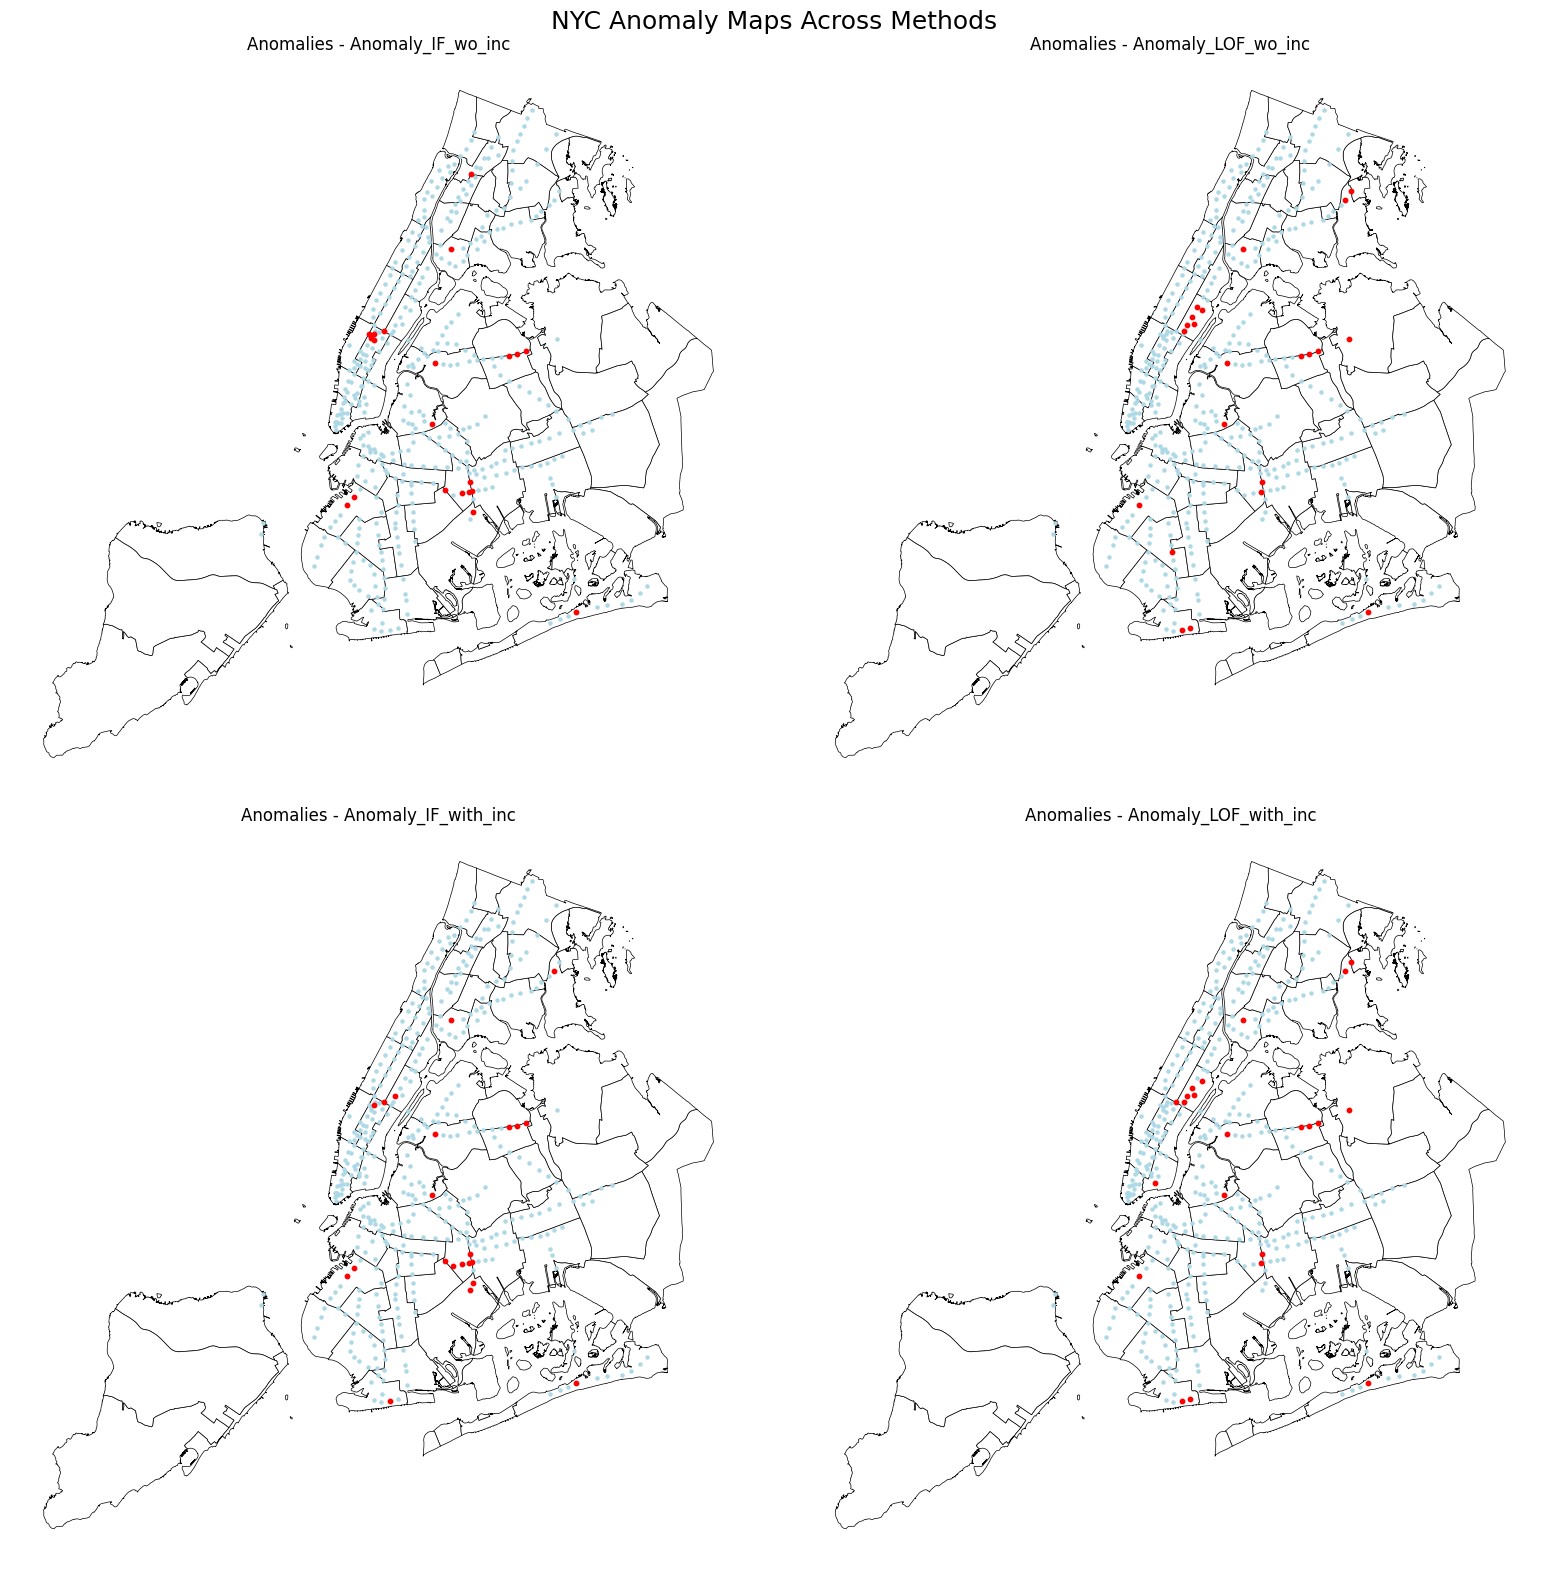

In [26]:
import geopandas as gpd
from shapely.geometry import Point

nyc_boundaries = gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
nyc_boundaries = nyc_boundaries.to_crs(epsg=3857) 

df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)


anomaly_cols = ['Anomaly_IF_wo_inc', 'Anomaly_LOF_wo_inc',
                'Anomaly_IF_with_inc', 'Anomaly_LOF_with_inc']

fig, axs = plt.subplots(2, 2, figsize=(16, 16))

for ax, col in zip(axs.flatten(), anomaly_cols):
    nyc_boundaries.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
    
    gdf_points[gdf_points[col] == 1].plot(ax=ax, color='lightblue', markersize=5)
    gdf_points[gdf_points[col] == -1].plot(ax=ax, color='red', markersize=10)

    ax.set_title(f"Anomalies - {col}", fontsize=12)
    ax.axis("off")

plt.suptitle("NYC Anomaly Maps Across Methods", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


## Causal Inference

In [27]:
from causalml.inference.meta import BaseSRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

df['black_high'] = (df['Black_Alon_pct'] >= df['Black_Alon_pct'].median()).astype(int)

features = ['MEAN_Median_Inc', 'White_Alon_pct', 'Hispanic_L_pct', 'Male_Total_pct', 'Female_Tot_pct']
X = df[features].fillna(df[features].median())
T = df['black_high']
Y = df['avg_fare_per_ride'].fillna(df['avg_fare_per_ride'].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

learner = BaseSRegressor(learner=LinearRegression())
learner.fit(X=X_scaled, treatment=T, y=Y)

ate = learner.estimate_ate(X=X_scaled, treatment=T, y=Y)
print(f"Estimated ATE (Black High vs Low): {ate[0]:.5f}")


INFO:causalml:Error metrics for group 1
INFO:causalml:    RMSE   (Control):     0.1038
INFO:causalml:    RMSE (Treatment):     0.0880
INFO:causalml:   sMAPE   (Control):     0.0349
INFO:causalml:   sMAPE (Treatment):     0.0301
INFO:causalml:    Gini   (Control):     0.7898
INFO:causalml:    Gini (Treatment):     0.7911


Estimated ATE (Black High vs Low): 0.03637


In [28]:
df['female_high'] = (df['Female_Tot_pct'] >= df['Female_Tot_pct'].median()).astype(int)
T_gender = df['female_high']

learner.fit(X=X_scaled, treatment=T_gender, y=Y)

ate_gender = learner.estimate_ate(X=X_scaled, treatment=T_gender, y=Y)

print(f"\nEstimated ATE (Female High vs Low): {ate_gender[0]:.5f}")


INFO:causalml:Error metrics for group 1
INFO:causalml:    RMSE   (Control):     0.0974
INFO:causalml:    RMSE (Treatment):     0.0965
INFO:causalml:   sMAPE   (Control):     0.0335
INFO:causalml:   sMAPE (Treatment):     0.0325
INFO:causalml:    Gini   (Control):     0.7837
INFO:causalml:    Gini (Treatment):     0.8402



Estimated ATE (Female High vs Low): 0.01576
